In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
!pip install PyPDF2

In [ ]:
import PyPDF2
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
from nltk.tokenize import sent_tokenize
from nltk.tokenize import word_tokenize
import nltk
import re
import string
from nltk.corpus import stopwords, brown
from nltk.tokenize import word_tokenize, sent_tokenize, RegexpTokenizer
from nltk.stem import WordNetLemmatizer


# 1. Data extraction

In [ ]:
filename = '/content/drive/My Drive/PMBOKGuide_5th_Ed.pdf'
open_filename = open(filename, 'rb')
ind_manifesto = PyPDF2.PdfFileReader(open_filename)

In [ ]:
ind_manifesto.getDocumentInfo()

{'/CreationDate': "D:20121220154602-05'00'",
 '/ModDate': "D:20130221141314+02'00'",
 '/Producer': 'Creo Normalizer JTP'}

In [ ]:
total_pages = ind_manifesto.numPages
total_pages

616

In [ ]:
!pip install textract

In [ ]:
def extract(subject):
    s=subject.lower()
    if s=="project scope management":
        start= 130
        end= 166
    elif s=="project time management":
        start=166
        end=218  
    else: 
        start=218
        end=252
    text  = ''
    # Lets loop through, to read each page from the pdf file
    while(start < end):
        # Get the specified number of pages in the document
        mani_page  = ind_manifesto.getPage(start)
        # Process the next page
        start += 1
        # Extract the text from the page
        text += mani_page.extractText()
    return text


In [ ]:
ptm = extract("project time management")
ptm

In [ ]:
pcm = extract("project cost management")
pcm

In [ ]:
psm=extract("project scope management")
psm

In [ ]:
#concaténation
text=psm+ptm+pcm
text

# 2. Data preprocessing

## 2.1 Tokenization

In [ ]:
import nltk
nltk.download('punkt')
from nltk.tokenize import sent_tokenize, word_tokenize 
sentences = sent_tokenize(text)
words = word_tokenize(text)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
words;

In [ ]:
sentences

## 2.2 Remove indesired ponctuation 

In [ ]:
import string
def remove_punctuation(text):
    # replacing the punctuations with no space, 
    # which in effect deletes the punctuation marks 
    translator = str.maketrans('', '', string.punctuation)
    # return the text stripped of punctuation marks
    return text.translate(translator)

In [ ]:
no_ponc=remove_punctuation(text)

## 2.3 Remove stopwords

In [ ]:
import nltk
import re
nltk.download('stopwords')
from nltk.corpus import stopwords
sw = set(stopwords.words('english')) - set(['is a'])
corpus=[]
def stopwords(text):

    
    text = re.sub('[^a-zA-Z]', ' ', text)
    
    text = [word.lower() for word in text.split() if word.lower() not in sw]
   
    j=" ".join(text)
    corpus.append(j)
    return j

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
no_stop=stopwords(no_ponc)

In [ ]:
no_stop

## 2.4 Lemmetization and Stemming

In [ ]:
import gensim
import nltk
nltk.download('wordnet')
from nltk.stem import SnowballStemmer,WordNetLemmatizer
def lemmatize_stemming(text):
    stemmer=SnowballStemmer('english')
    return stemmer.stem(WordNetLemmatizer().lemmatize(text, pos='v'))
def preprocess(text):
    result = []
    for token in gensim.utils.simple_preprocess(text):
        if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 3:
            result.append(lemmatize_stemming(token))
    return result

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
processed = preprocess(no_stop)
processed

## 2.5 POS Tagging

In [ ]:
tags=nltk.pos_tag(processed)

In [ ]:
tags

## 2.6 Chunking

In [ ]:
import nltk
grammar="NP:{<DT>?<JJ>*<NN>}"
parser=nltk.RegexpParser(grammar)
output=parser.parse(tags)
print(output)
#output.draw()

# 4. Bag of words

In [ ]:
dictionary = gensim.corpora.Dictionary([no_stop.split()])
count = 0
for k, v in dictionary.iteritems():
    print(k, v)
    count += 1
    if count > 10:
        break

        

0 aa
1 abbreviated
2 ability
3 able
4 abstract
5 ac
6 accelerating
7 acceptable
8 acceptance
9 accepted
10 accepts


In [ ]:
dictionary.filter_extremes(no_below=15, no_above=0.5, keep_n=100000)

# 5. Doc2bow

In [ ]:
import gensim
from gensim import corpora
bow_corpus = [dictionary.doc2bow(doc) for doc in [no_stop.split()]]

# turn our tokenized documents into a id <-> term dictionary
dictionary = corpora.Dictionary([no_stop.split()])
# convert tokenized documents into a document-term matrix
bow_corpus = [dictionary.doc2bow(text) for text in [no_stop.split()]]

In [ ]:
list(dictionary.values())

In [ ]:
bow_doc_0 = bow_corpus[0]
for i in range(len(bow_doc_0)):
    print("Word {} (\"{}\") appears {} time.".format(bow_doc_0[i][0], 
                                               dictionary[bow_doc_0[i][0]], 
bow_doc_0[i][1]))

In [ ]:
import pandas as pd
df = pd.DataFrame([no_stop])
df.columns = ['script']
df.index = ['index']
df

,script
index,project management institute guide project man...


In [ ]:
#  Counting the occurrences of tokens and building a sparse matrix of documents x tokens.
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np

corpus = df.script
vect = CountVectorizer(stop_words='english')

# Transforms the data into a bag of words
data_vect = vect.fit_transform(corpus)

In [ ]:
feature_names = vect.get_feature_names()
data_vect_feat = pd.DataFrame(data_vect.toarray(), columns=feature_names)
data_vect_feat.index = df.index
data_vect_feat

,aa,abbreviated,ability,able,abstract,ac,accelerating,acceptable,acceptance,accepted,accepts,accompany,accomplish,accomplished,accomplishing,accomplishment,accordance,according,account,accounting,accounts,accumulate,accumulated,accuracy,accurate,accurately,acd,achievable,achieve,achieved,achieving,acknowledging,acquire,acquired,acquireproject,acquisition,acted,action,actions,active,...,voice,voting,waits,walkthroughs,warning,warranting,wave,way,ways,wbs,wbscreate,webpages,weekly,weeks,weight,weighted,welldocumented,wellfacilitated,whatif,whenhistorical,wide,widely,winformationproject,withheld,wno,wo,words,work,working,works,workshop,workshops,workweek,worstcase,writing,written,xed,yards,yen,zero
index,1,1,3,4,1,24,1,9,19,14,1,1,3,11,1,1,1,3,20,5,10,1,1,20,8,1,1,2,4,4,1,1,1,2,3,1,1,18,12,2,...,1,2,1,1,1,1,6,10,7,106,1,1,1,8,3,1,1,1,4,1,1,2,1,2,1,1,1,263,4,3,2,9,1,3,4,1,2,2,1,5


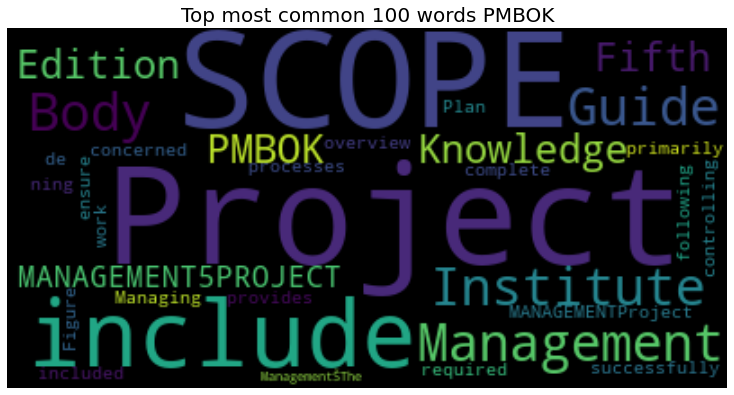

In [ ]:
from wordcloud import WordCloud, STOPWORDS
import imageio
import matplotlib.pyplot as plt
import nltk


# Get 100 words based on the 
words_except_stop_dist = nltk.FreqDist(w for w in words[:100]) 
wordcloud = WordCloud(stopwords=set(STOPWORDS),background_color='black').generate(" ".join(words_except_stop_dist))
plt.imshow(wordcloud,interpolation = 'bilinear')
fig=plt.gcf()
fig.set_size_inches(10,12)
plt.axis('off')
plt.title("Top most common 100 words PMBOK",fontsize=20)
plt.tight_layout(pad=0)
plt.savefig('PMBOK_cost_time_scop_top_100.jpeg')

# 6. TF-ID

In [ ]:
import gensim.downloader as api
from gensim import corpora, models
from gensim.corpora import Dictionary
from gensim.models import TfidfModel
tfidf = models.TfidfModel(bow_corpus)
corpus_tfidf = tfidf[bow_corpus]
from pprint import pprint
for doc in corpus_tfidf:
    pprint(doc)


In [ ]:
sentences = nltk.sent_tokenize(no_stop)

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
word_vectorizer = TfidfVectorizer(tokenizer=processed_docs, stop_words='english')
all_word_vectors = word_vectorizer.fit_transform(for sent in sentences)

In [ ]:
£print(corpus_tfidf

TfidfModel(num_docs=1, num_nnz=2600)


# 7. LDA

In [ ]:
lda_model = gensim.models.LdaMulticore(bow_corpus, num_topics=10, id2word=dictionary,chunksize=100,iterations=25, passes=2, workers=4)

In [ ]:
for idx, topic in lda_model.print_topics(-1):
    print('Topic: {} \nWords: {}'.format(idx, topic))

Topic: 0 
Words: 0.049*"project" + 0.033*"management" + 0.019*"schedule" + 0.013*"activity" + 0.012*"process" + 0.011*"plan" + 0.010*"work" + 0.010*"pmi" + 0.010*"scope" + 0.010*"cost"
Topic: 1 
Words: 0.031*"project" + 0.015*"management" + 0.010*"schedule" + 0.009*"cost" + 0.008*"scope" + 0.007*"pmi" + 0.007*"guide" + 0.007*"activity" + 0.006*"work" + 0.006*"process"
Topic: 2 
Words: 0.027*"project" + 0.016*"management" + 0.012*"cost" + 0.011*"schedule" + 0.009*"scope" + 0.008*"activity" + 0.007*"work" + 0.007*"process" + 0.007*"requirements" + 0.006*"pmi"
Topic: 3 
Words: 0.033*"project" + 0.030*"management" + 0.014*"schedule" + 0.010*"scope" + 0.010*"cost" + 0.009*"work" + 0.009*"activity" + 0.006*"pmi" + 0.006*"guide" + 0.006*"process"
Topic: 4 
Words: 0.031*"project" + 0.020*"management" + 0.016*"schedule" + 0.012*"scope" + 0.010*"work" + 0.009*"activity" + 0.008*"process" + 0.008*"cost" + 0.007*"pmi" + 0.007*"section"
Topic: 5 
Words: 0.032*"project" + 0.016*"management" + 0.013*

# 8. LDA + TF_ID

In [ ]:
lda_model_tfidf = gensim.models.LdaMulticore(corpus_tfidf, num_topics=10, id2word=dictionary,chunksize=100,iterations=25, passes=2, workers=4)
for idx, topic in lda_model_tfidf.print_topics(-1):
    print('Topic: {} Word: {}'.format(idx, topic))

Topic: 0 Word: 0.000*"planfigure" + 0.000*"planned" + 0.000*"placed" + 0.000*"placing" + 0.000*"plan" + 0.000*"plana" + 0.000*"planasp" + 0.000*"plancumulative" + 0.000*"plandescribed" + 0.000*"physical"
Topic: 1 Word: 0.000*"planfigure" + 0.000*"planned" + 0.000*"placed" + 0.000*"placing" + 0.000*"plan" + 0.000*"plana" + 0.000*"planasp" + 0.000*"plancumulative" + 0.000*"plandescribed" + 0.000*"physical"
Topic: 2 Word: 0.000*"planfigure" + 0.000*"planned" + 0.000*"placed" + 0.000*"placing" + 0.000*"plan" + 0.000*"plana" + 0.000*"planasp" + 0.000*"plancumulative" + 0.000*"plandescribed" + 0.000*"physical"
Topic: 3 Word: 0.000*"planfigure" + 0.000*"planned" + 0.000*"placed" + 0.000*"placing" + 0.000*"plan" + 0.000*"plana" + 0.000*"planasp" + 0.000*"plancumulative" + 0.000*"plandescribed" + 0.000*"physical"
Topic: 4 Word: 0.000*"planfigure" + 0.000*"planned" + 0.000*"placed" + 0.000*"placing" + 0.000*"plan" + 0.000*"plana" + 0.000*"planasp" + 0.000*"plancumulative" + 0.000*"plandescribed"

# 9. Evaluation

## Evaluation using LDA Bag of Words model

In [ ]:
for index, score in sorted(lda_model[bow_corpus[14]], key=lambda tup: -1*tup[1]):
    print("\nScore: {}\t \nTopic: {}".format(score, lda_model.print_topic(index, 10)))


Score: 0.6330733299255371	 
Topic: 0.171*"mang" + 0.148*"froid" + 0.129*"tout" + 0.122*"personnel" + 0.099*"frit" + 0.063*"restaur" + 0.059*"command" + 0.050*"sandwich" + 0.050*"serv" + 0.032*"cest"

Score: 0.2335716336965561	 
Topic: 0.171*"sal" + 0.128*"tabl" + 0.115*"attent" + 0.102*"personnel" + 0.071*"plus" + 0.065*"serv" + 0.061*"froid" + 0.058*"sandwich" + 0.051*"manqu" + 0.047*"command"

Score: 0.016672134399414062	 
Topic: 0.144*"command" + 0.114*"pass" + 0.110*"frit" + 0.100*"driv" + 0.093*"attent" + 0.083*"restaur" + 0.076*"personnel" + 0.038*"cest" + 0.035*"manqu" + 0.034*"toujour"

Score: 0.016672035679221153	 
Topic: 0.209*"tout" + 0.128*"cest" + 0.099*"command" + 0.097*"froid" + 0.079*"mang" + 0.076*"sandwich" + 0.075*"plus" + 0.045*"frit" + 0.034*"personnel" + 0.029*"pass"

Score: 0.01666986756026745	 
Topic: 0.302*"command" + 0.134*"driv" + 0.088*"fois" + 0.078*"personnel" + 0.055*"restaur" + 0.046*"mang" + 0.046*"tout" + 0.034*"attent" + 0.034*"cest" + 0.029*"manqu"


## Evaluation using LDA TF-IDF model

In [ ]:
for index, score in sorted(lda_model_tfidf[bow_corpus[14]], key=lambda tup: -1*tup[1]):
    print("\nScore: {}\t \nTopic: {}".format(score, lda_model_tfidf.print_topic(index, 10)))



Score: 0.8499695658683777	 
Topic: 0.173*"tout" + 0.150*"froid" + 0.095*"sandwich" + 0.095*"serv" + 0.093*"command" + 0.059*"mang" + 0.049*"personnel" + 0.041*"sal" + 0.040*"attent" + 0.036*"frit"

Score: 0.0166741032153368	 
Topic: 0.158*"plus" + 0.154*"attent" + 0.128*"restaur" + 0.102*"command" + 0.065*"serv" + 0.057*"personnel" + 0.051*"pass" + 0.051*"manqu" + 0.034*"mang" + 0.032*"tout"

Score: 0.01667359285056591	 
Topic: 0.243*"personnel" + 0.140*"command" + 0.097*"pass" + 0.079*"pir" + 0.077*"driv" + 0.064*"sal" + 0.055*"fois" + 0.047*"toujour" + 0.027*"cest" + 0.024*"mang"

Score: 0.016670508310198784	 
Topic: 0.265*"froid" + 0.186*"mang" + 0.134*"sandwich" + 0.078*"toujour" + 0.070*"cest" + 0.068*"restaur" + 0.029*"command" + 0.026*"client" + 0.024*"attent" + 0.022*"manqu"

Score: 0.01667034812271595	 
Topic: 0.166*"cest" + 0.148*"sal" + 0.102*"client" + 0.090*"personnel" + 0.079*"tabl" + 0.074*"command" + 0.065*"pass" + 0.056*"plus" + 0.054*"restaur" + 0.043*"attent"

Score

In [ ]:
from gensim.models import CoherenceModel
# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model_tfidf, texts=processed_docs, dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Coherence Score:  0.21666423868157847


#  10.Test

In [ ]:
unseen_document = "j'aime tout au macdo , fast food, endroit et atmosphère sont magnifiques "
bow_vector = dictionary.doc2bow(preprocess(unseen_document))
for index, score in sorted(lda_model[bow_vector], key=lambda tup: -1*tup[1]):
    print("Score: {}\t Topic: {}".format(score, lda_model.print_topic(index, 5)))

Score: 0.5499685406684875	 Topic: 0.209*"tout" + 0.128*"cest" + 0.099*"command" + 0.097*"froid" + 0.079*"mang"
Score: 0.05001497641205788	 Topic: 0.171*"mang" + 0.148*"froid" + 0.129*"tout" + 0.122*"personnel" + 0.099*"frit"
Score: 0.05000494793057442	 Topic: 0.309*"froid" + 0.085*"command" + 0.082*"sandwich" + 0.078*"toujour" + 0.062*"fois"
Score: 0.05000436678528786	 Topic: 0.302*"command" + 0.134*"driv" + 0.088*"fois" + 0.078*"personnel" + 0.055*"restaur"
Score: 0.050003375858068466	 Topic: 0.134*"toujour" + 0.115*"pir" + 0.099*"pass" + 0.075*"cest" + 0.075*"tabl"
Score: 0.050002824515104294	 Topic: 0.171*"sal" + 0.128*"tabl" + 0.115*"attent" + 0.102*"personnel" + 0.071*"plus"
Score: 0.05000067874789238	 Topic: 0.144*"command" + 0.114*"pass" + 0.110*"frit" + 0.100*"driv" + 0.093*"attent"
Score: 0.050000227987766266	 Topic: 0.146*"plus" + 0.119*"fois" + 0.112*"driv" + 0.110*"pir" + 0.101*"frit"
Score: 0.05000005289912224	 Topic: 0.170*"command" + 0.136*"manqu" + 0.085*"toujour" + 0.0

In [ ]:
coherence_model_lda = CoherenceModel(model=lda_model_tfidf, texts=processed_docs, dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Coherence Score:  0.21666423868157847


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


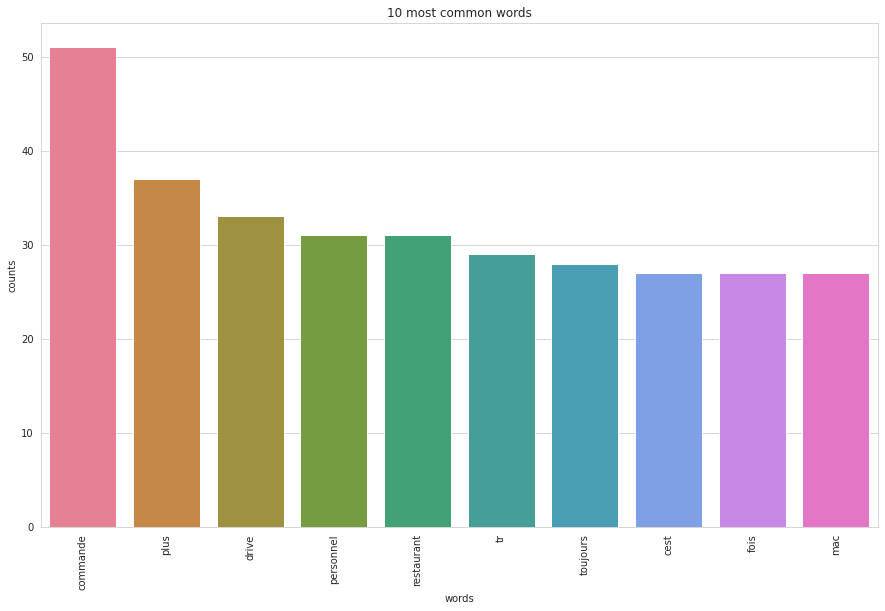

In [ ]:
 #Load the library with the CountVectorizer method
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
%matplotlib inline
# Helper function
def plot_10_most_common_words(count_data, count_vectorizer):
    import matplotlib.pyplot as plt
    words = count_vectorizer.get_feature_names()
    total_counts = np.zeros(len(words))
    for t in count_data:
        total_counts+=t.toarray()[0]
    
    count_dict = (zip(words, total_counts))
    count_dict = sorted(count_dict, key=lambda x:x[1], reverse=True)[0:10]
    words = [w[0] for w in count_dict]
    counts = [w[1] for w in count_dict]
    x_pos = np.arange(len(words)) 
    
    plt.figure(2, figsize=(15, 15/1.6180))
    plt.subplot(title='10 most common words')
    sns.set_context("notebook", font_scale=1.25, rc={"lines.linewidth": 2.5})
    sns.barplot(x_pos, counts, palette='husl')
    plt.xticks(x_pos, words, rotation=90) 
    plt.xlabel('words')
    plt.ylabel('counts')
    plt.show()
# Initialise the count vectorizer with the English stop words
count_vectorizer = CountVectorizer(stop_words=['french'])
# Fit and transform the processed titles
count_data = count_vectorizer.fit_transform(df['review_body'])
# Visualise the 10 most common words
plot_10_most_common_words(count_data, count_vectorizer)